# Sound of Nature

Solution author: Asandei Stefan-Alexandru

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18, ResNet18_Weights
from torchmetrics.classification import MulticlassF1Score

In [17]:
root_path = "/home/stefan/ioai-prep/kits/sound_of_nature" # replace this with your dataset path
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 32
epochs = 5
lr = 3e-4

seed = 42
torch.random.manual_seed(seed)

# Data

In [18]:
train_df = pd.read_csv(os.path.join(root_path, "train.csv"))
test_df = pd.read_csv(os.path.join(root_path, "test.csv"))

le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["class"])
num_classes = len(le.classes_)

In [19]:
class AudioDataset(Dataset):
    def __init__(self, df, audio_dir, sr=16000, length=5, is_train=False):
        self.df = df
        self.audio_dir = audio_dir
        self.sr = sr
        self.target_len = sr * length
        self.is_train = is_train
        self.mel_transform = T.MelSpectrogram(sample_rate=sr, n_mels=64)

        # SpecAugment layers
        self.freq_mask = T.FrequencyMasking(freq_mask_param=15)
        self.time_mask = T.TimeMasking(time_mask_param=35)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        wav, sr = torchaudio.load(
            os.path.join(self.audio_dir, f"{row['sampleID']}.wav")
        )

        if sr != self.sr:
            wav = T.Resample(sr, self.sr)(wav)

        if wav.shape[1] < self.target_len:
            wav = torch.nn.functional.pad(wav, (0, self.target_len - wav.shape[1]))
        else:
            wav = wav[:, : self.target_len]

        # Waveform Augmentation
        if self.is_train and random.random() < 0.3:
            noise = torch.randn_like(wav) * 0.005
            wav = wav + noise

        mel = torch.log(self.mel_transform(wav) + 1e-9)

        if self.is_train:
            mel = self.freq_mask(mel)
            mel = self.time_mask(mel)

        ret = {"mel": mel, "sample_id": str(row["sampleID"])}
        if "label" in row:
            ret["label"] = row["label"]
        return ret

    def __len__(self):
        return len(self.df)

In [20]:
train_df, val_df = train_test_split(
    train_df, test_size=0.2, stratify=train_df["label"], random_state=seed
)

train_set = AudioDataset(train_df, f"{root_path}/audio", is_train=True)
val_set = AudioDataset(val_df, f"{root_path}/audio", is_train=False)

train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size, num_workers=0)

test_dataset = AudioDataset(test_df, f"{root_path}/audio", is_train=False)
test_loader = DataLoader(test_dataset, batch_size)

In [21]:
# sanity check
batch = next(iter(train_loader))
{k:batch[k].shape for k in ["mel", "label"]}

{'mel': torch.Size([32, 1, 64, 401]), 'label': torch.Size([32])}

sample of cat


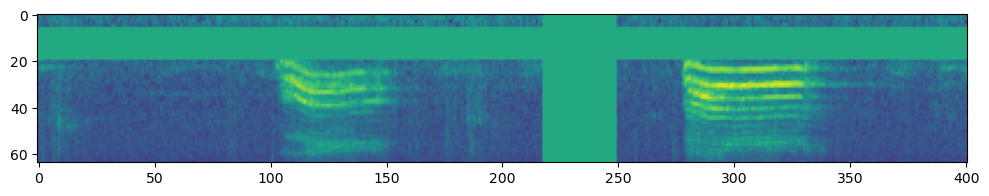

In [22]:
sample_idx = 1
sample = batch["mel"][sample_idx].permute(1, 2, 0)
print(f"sample of {le.inverse_transform([batch["label"][sample_idx]])[0]}")

plt.figure(figsize=(12, 3))
plt.imshow(sample)

# Model

In [23]:
class AudioResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        # Adapt for 1-channel mel-spectrogram
        self.model.conv1 = nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)


model = AudioResNet(num_classes).to(device)

# Training

In [24]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()
f1_metric = MulticlassF1Score(num_classes=num_classes, average="macro").to(device)

best_f1 = 0.0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        mel, label = batch["mel"].to(device), batch["label"].to(device)

        optimizer.zero_grad()
        output = model(mel)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            mel, label = batch["mel"].to(device), batch["label"].to(device)
            output = model(mel)
            f1_metric.update(output, label)

    val_f1 = f1_metric.compute().item()
    f1_metric.reset()

    print(f"Loss: {train_loss/len(train_loader):.4f} | Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "best_model.pth")

Epoch 1/5: 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Loss: 1.8000 | Val F1: 0.5207


Epoch 2/5: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Loss: 1.1418 | Val F1: 0.7705


Epoch 3/5: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Loss: 0.7535 | Val F1: 0.8292


Epoch 4/5: 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


Loss: 0.5028 | Val F1: 0.7554


Epoch 5/5: 100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Loss: 0.5276 | Val F1: 0.8076


# Submission

In [25]:
preds, sample_ids = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Inference"):
        mel = batch["mel"].to(device)
        output = model(mel)
        p = torch.argmax(output, dim=1).cpu().tolist()
        preds.extend(p)
        sample_ids.extend(batch["sample_id"])

Inference: 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]


In [26]:
submission = pd.DataFrame(
    {"sampleID": sample_ids, "class": [le.classes_[p] for p in preds]}
)

submission.head()

,sampleID,class
0,S_00003,rain
1,S_00011,chirping_birds
2,S_00013,hen
3,S_00017,rain
4,S_00019,hen


In [27]:
submission.to_csv("solution.csv", index=False)